In [1]:
import sys
sys.executable

'c:\\users\\jorda\\desktop\\machine-learning-blueprints\\env\\scripts\\python.exe'

# Text Similarity Methods

When attempting to perform information retreival in the form of text matching it is important to consider two core ideas:

1. Lexical Similarity
2. Semantic Similarity.

The former involves discovering text pairs that have the same meaning, even when none of the words in the text pairs are the same. This contextual understanding is what represents a good target.

## Get a Sample Dataset - Amazon Reviews

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_json('../../data/amazon-electronics-reviews.json', lines=True)
df = df[['reviewText']]
df.head(2)

,reviewText
0,We got this GPS for my husband who is an (OTR)...
1,"I'm a professional OTR truck driver, and I bou..."


## Method #1 - Jaccard Similarity

This represents typically lemmatising the words in the text pairs and calculating the outcome based on the lexical similarity. This would fail in cases such as the below:

Sentence 1: President greets the press in Chicago

Sentence 2: Obama speaks in Illinois

These pairs represent the same intent, but would score poorly using the Jaccard score.

## Define Contextual Input Test Pair Based on Above Insights

In [1]:
ss1 = 'The president greets the press in Chicago'
ss2 = 'Obama speaks to the media in Illinois'

## Method 2 - Cosine Similarity - Count Vectors

In [5]:
# packages
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return cosine

cosine_distance_countvectorizer_method(ss1 , ss2)\

Similarity of two sentences are equal to  37.8 %


0.6220355269907728

### Outcome

This method focuses only on the lexicon, not the context of words, which leads to a large cosine score. We want to see a score close to 0.

### Interpreting Cosine Distance Measure

In [6]:
v1 = [5,5,5,5,5]
v2 = [3,7,3,7,3]
v3 = [1,9,1,9,1]

print(distance.cosine(v1, v1))
print(distance.cosine(v1, v2))
print(distance.cosine(v1, v3))

0.0
0.07999999999999996
0.26887384498606903


You will see this is a score that increases the further apart the two input vectors are. Closer to 0 = better.

## Method 3 - Pre Trained Word Embeddings

For Example, ‘President’ vs ‘Prime minister’, ‘Food’ vs ‘Dish’, ‘Hi’ vs ‘Hello’ should be considered similar. For this, converting the words into respective word vectors, and then, computing the similarities can address this problem.

### Text Cleaning Method

In [21]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pandas as pd

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()
    
    # TODO - Add Stemmer / Lemma

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Glove Model

In [50]:
gloveFile = "../../data/glove.6B.100d.txt"
import numpy as np

def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

model = loadGloveModel(gloveFile)

Loading Glove Model
Done. 400001  words loaded!


Show the 100 values within the vector representing 'hello' as an example.

In [51]:
model['hello']

array([ 0.26688  ,  0.39632  ,  0.6169   , -0.77451  , -0.1039   ,
        0.26697  ,  0.2788   ,  0.30992  ,  0.0054685, -0.085256 ,
        0.73602  , -0.098432 ,  0.5479   , -0.030305 ,  0.33479  ,
        0.14094  , -0.0070003,  0.32569  ,  0.22902  ,  0.46557  ,
       -0.19531  ,  0.37491  , -0.7139   , -0.51775  ,  0.77039  ,
        1.0881   , -0.66011  , -0.16234  ,  0.9119   ,  0.21046  ,
        0.047494 ,  1.0019   ,  1.1133   ,  0.70094  , -0.08696  ,
        0.47571  ,  0.1636   , -0.44469  ,  0.4469   , -0.93817  ,
        0.013101 ,  0.085964 , -0.67456  ,  0.49662  , -0.037827 ,
       -0.11038  , -0.28612  ,  0.074606 , -0.31527  , -0.093774 ,
       -0.57069  ,  0.66865  ,  0.45307  , -0.34154  , -0.7166   ,
       -0.75273  ,  0.075212 ,  0.57903  , -0.1191   , -0.11379  ,
       -0.10026  ,  0.71341  , -1.1574   , -0.74026  ,  0.40452  ,
        0.18023  ,  0.21449  ,  0.37638  ,  0.11239  , -0.53639  ,
       -0.025092 ,  0.31886  , -0.25013  , -0.63283  , -0.0118

### Get the similarity score

In [80]:
import scipy

def cosine_distance_wordembedding_method(s1, s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    
    s1 = check_word_in_volcab(s1)
    s2 = check_word_in_volcab(s2)
    
    vector_1 = np.mean([model[word] for word in s1],axis=0)
    vector_2 = np.mean([model[word] for word in s2],axis=0)
    
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance assess that our two sentences are similar to',round((1-cosine)*100,2),'%')
    return cosine


def check_word_in_volcab(sentence):
    avaliable_words = []
    for word in sentence:
        if word in model:
            avaliable_words.append(word)
    return avaliable_words

        
cosine_distance_wordembedding_method(ss1, ss2)  

Word Embedding method with a cosine distance assess that our two sentences are similar to 77.15 %


0.22852704995563478

This showcases for this example a signficant improvement in match quality using word embeddings.

### Let's visualise the embeddings at the word level...

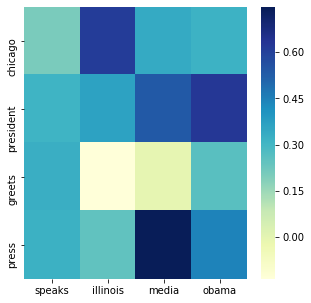

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def cosine_distance_between_two_words(word1, word2):
    return (1 - scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def heat_map_matrix_between_two_sentences(s1,s2):
    df = calculate_heat_matrix_for_two_sentences(s1,s2)
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    return ax_blue

heat_map_matrix_between_two_sentences(ss1,ss2)

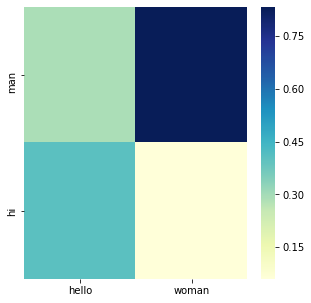

In [18]:
heat_map_matrix_between_two_sentences('hi, man','hello, woman')

Let's Apply this method to a subset of our larger dataset to determine the closest review matches...

In [107]:
# Get a target Review (The first) and N others (seqeuntial)
input_text = df[:1]['reviewText'].values[0]
df_s = df.sample(5)

In [108]:
input_text # Lets check out our target.

'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!'

In [109]:
# Apply a function onto df_s returning the match scores as a new column
def similarity_score(sentence_a, sentence_b):
    return cosine_distance_wordembedding_method(sentence_a, sentence_b)

df_s['similarity'] =  df_s.apply(lambda x: similarity_score(x.reviewText, input_text), axis=1)

Word Embedding method with a cosine distance assess that our two sentences are similar to 76.12 %
Word Embedding method with a cosine distance assess that our two sentences are similar to 93.06 %
Word Embedding method with a cosine distance assess that our two sentences are similar to 89.18 %
Word Embedding method with a cosine distance assess that our two sentences are similar to 93.87 %
Word Embedding method with a cosine distance assess that our two sentences are similar to 96.11 %


In [110]:
pd.set_option('display.max_colwidth', -1)  # or 199
df_s.head(10)

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,reviewText,similarity
104082,"bought these to install some speakers in my 1990 Mustang, they fit the speakers snugly and plug right into the factory wiring. Couldn't expect more.",0.238817
230080,"I got this camera for my wife its her first digital camera and its a great entry level unit. Very easy to operate and takes nice photos. The price was right at just under a $100. I like that it uses AA bateries same as my Vivitar and uses the SD cards, the price on those are really dropping the 256 are $10. It came with the docking device, I may buy the printer, but we dont print a lot of photos. I like looking at them on the PC screeen or I transfer to a CD and watch on the TV.",0.069383
243135,"For under $30, this is an awesome buy. No complaints about card performance. Seems to work excellently.",0.108249
223145,"I bought this camera in May, it's my first ""real"" camera. A few things I haven't seen mentioned: you can use at least a 4GB card, that was the largest when I bought the camera and it's working fine; there are add-on lenses, I just bought a wide angle and 2X telephoto, and I see there is also a 3X. There's another lens you can buy for closeups. All you need is the adaptor, you can also use filters and an external flash.This is a very versatile but easy-to-use camera. I've talked to Canon Customer Support once (when I upgraded the memory card) and they were great, but have yet to read the manual. There are all kinds of manual settings to play with, there is also a DVD tutorial available through Amazon that I'm thinking about. Mostly I use automatic or portrait (blurs the background). There's a Canon Yahoo group as well.Get a tripod if you are shooting in low light, those are the ones that come out blurry for me. Video is sharp, but you can see how much I move ;-) Someone earlier wanted a sports setting, try Kids&Pets.;This is a great camera, the swivel screen is very cool and you'll be amazed at the shots you can get. The more you learn, the more you can do.",0.061265
141739,"I might be old fashioned but my grandparents had appliances that are still working 35 years after purchase. I think something like this simple device with no moving parts ought to last more than a year and a half. So I give it a star for each year it lived. I'm being generous with the half year. Now, I'm off to order a different brand.",0.038927


## Method 4 - Soft Cosine Similarity with Fast Text Embeddings

This also could technically work with Glove embeddings, but the gensim API exemplar was much simpler to implement as reference code.

In [6]:
from gensim.matutils import softcossim 
from gensim import corpora
from gensim.utils import simple_preprocess
import gensim.downloader as api

# Get the fast text embedding model
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [22]:
documents = [ss1, ss2]

# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in documents])

# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity_matrix` (Method will be removed in 4.0.0, use gensim.models.keyedvectors.WordEmbeddingSimilarityIndex instead).
  import sys


In [23]:
# Convert the sentences into bag-of-words vectors.
sent_1 = dictionary.doc2bow(simple_preprocess(ss1))
sent_2 = dictionary.doc2bow(simple_preprocess(ss2))
sentences = [sent_1, sent_2]

Get the similarity score between the two input sentences.

In [24]:
print(softcossim(sent_1, sent_2, similarity_matrix))

0.6226904851163964


c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `softcossim` (Function will be removed in 4.0.0, use gensim.similarities.termsim.SparseTermSimilarityMatrix.inner_product instead).
  """Entry point for launching an IPython kernel.


Helper method to create a pandas matrix of similarities across several documents.

In [25]:
import numpy as np
import pandas as pd

def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array)
    cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return cossim_mat

create_soft_cossim_matrix(sentences)

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `softcossim` (Function will be removed in 4.0.0, use gensim.similarities.termsim.SparseTermSimilarityMatrix.inner_product instead).
  import sys


,0,1
0,1.00,0.62
1,0.62,1.00


#### Outcome

The similarity score in this case is lower, but given we changed the word embedding method while using a soft cosine distance it does not directly yeild a fair comparison - revist indepedently in future.

## Method 5 - W2V + SIF - Google News Model 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

for c in range(len([ss1, ss2])):
    corpus[c] = pre_process(corpus[c])
    
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_vectorizer.fit(corpus)
feature_vectors = tfidf_vectorizer.transform(corpus)

Using Word2Vec embeddings, word will be represented as a multidimensional array. The two unsupervised algorithms, Skip-gram, and CBoW are used to generate word embeddings.

In [28]:
from gensim.models import Word2Vec
word_emb_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


SIF Weighting Function

In [29]:
from collections import Counter
import itertools

def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=word_emb_model):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    embedding_size = 300 # size of vectore in word embeddings
    a = 0.001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [31]:
sentence_set = get_sif_feature_vectors(ss1, ss2)

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [32]:
get_cosine_similarity(sentence_set[0], sentence_set[1])

0.6518640962891309

#### Outcome

Another sound implementation of a comparison appraoch

## Method 5 - Doc2Vec - From Scratch

This can be easily modified to be used on a custom dataset (internal / domain cases?)

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk

data = [ss1, ss2]
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

In [8]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
c:\users\jorda\desktop\machine-learning-blueprints\env\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [9]:
test_data = word_tokenize("Obama is speaking now".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

V1_infer [ 0.00086425 -0.02024958 -0.00186852  0.0005197   0.01645884  0.01017107
  0.00682817 -0.02136143  0.01324157  0.0106261   0.01132278  0.00468208
  0.00891216  0.00951966 -0.01600788  0.01224463  0.0074051  -0.02235314
 -0.02260971  0.01266726]
[('0', 0.9876613616943359)]
[-0.09986771 -0.2762324   0.15846145  0.42846113  0.46483958 -0.08939951
 -0.63508695  0.20074709  0.03372648  0.13833457  0.17253941  0.06296055
 -0.27815953 -0.3078336   0.19920686 -0.5326984  -0.11055823  0.0959372
  0.01647971 -0.03332953]


## Method 6 - Universal Sentence Encoder.

TODO

## Method 7 - BERT

TODO

## Method 8 - Siamese Neural Nets

TODO

## TODO

- Perform a comparison on a reference open source data set (STS dataset)
- BERT + Siamese Neural Nets + USE
- Apply a given distance measure to all rows in a dataframe.
- Bring in a TFIDF Variant as an additional basic benchmark.
- Basic word2Vec variant to contrast with Glove.
- Is it important to bring sentiment into play? contextual similarity + sentiment similarity?
- Lacking cleaning / EDA analysis.
- Does similarity need to also account for topics?
- Once applied to all rows together you need a threshold defined in terms of reasonable cut off.
- Consider a clustering approach.
- We would need an open source test set and a domain test set, work with product to get a set of 500 pairs with some assigned sim score.
- Use consistent distance or similarity score for cosine, currently I am jumping between both.

## Resources

- https://github.com/nlptown/nlp-notebooks/blob/master/Simple%20Sentence%20Similarity.ipynb
    - Great reference code for various similarity measures.
- https://medium.com/@adriensieg/text-similarities-da019229c894
- https://github.com/adsieg/text_similarity
- https://nlp.stanford.edu/projects/glove/
- https://www.cs.toronto.edu/~lczhang/360/lec/w06/w2v.html
- http://nlp.town/blog/sentence-similarity/
    - references benchmarks and datasets to enable some comparison if required.
- https://www.machinelearningplus.com/nlp/cosine-similarity/
- https://medium.com/@Intellica.AI/comparison-of-different-word-embeddings-on-text-similarity-a-use-case-in-nlp-e83e08469c1c#:~:text=Text%20Similarity%20is%20one%20of,perform%20any%20machine%20learning%20task.
    - Really good article on w2v approach. Stresses importance of decision function and a domain test process
- https://towardsdatascience.com/the-best-document-similarity-algorithm-in-2020-a-beginners-guide-a01b9ef8cf05
- https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5